## Abstract

### Goal

For now, we are trying to predict the top level product category like Drugs, Counterfeit, Services etc. from listing metadata on the Agora marketplace (2014‑2015).

* Feature sets we will start with  are `origin`, `destination`, `btc price`, vendor `rating/score`, number of `deals` for now.

Models we are using for now are:   

- `Logistic Regression (OvR)` — linear baseline
- `Random Forest Classifier` — non-linear benchmark

Evaluation:

- `Accuracy` and `macro-averaged F1 score` on a 20% test set of the total dataset.
- `5-fold cross-validation` to check for variance and overfitting

### Necessary Imports:


In [6]:
# If running for the first time, uncomment this line:
# %pip install -q kagglehub

import kagglehub
import zipfile, shutil, warnings
from pathlib import Path

# Core
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib inline
sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

# ML Model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


/Users/prashanthbabu/anaconda3/envs/ml-0451/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Pre-Processing:

In our code below we load our CSV and go ahead and start ceaning our data. We Printed the head of OUr CSV to view the different features and teh different values our Coumns and rows have. We looked at the our Agora dataset which had 109,689 rows and 9 columns, including things like vendor name, product category, item description, price, origin, destination, rating, and remarks. After cleaning up the column names and removing leading/trailing spaces, we noticed that some of the entries had missing values or messy formatting. For example, the price column included the word "BTC" as the price of things were given in Bitcoin so we stripped it out and converted all prices to USD using the average Bitcoin value from 2014–2015. We also log-transformed the price to make the distribution more balanced. For origin and destination, we normalized common patterns like turning "us" or "u.s.a" into just "USA". Ratings and number of deals were also split into separate columns from one combined string. Lastly, we broke down the full product category (which looked like "Drugs/RCs/…") into multiple levels so we could use the broader one (cat1) as our target label and so we could train and experiemnt with a multiclass logitic regression model. After all this preprocessing, we ended up with 109,096 clean rows, ready for analysis and modeling.

In [7]:
#load csv file
df_raw = pd.read_csv("Agora.csv", encoding="latin1")
print(f"Rows: {len(df_raw):,} | Cols: {df_raw.shape[1]}")
df_raw.head(3)


Rows: 109,689 | Cols: 9


,Vendor,Category,Item,Item Description,Price,Origin,Destination,Rating,Remarks
0,CheapPayTV,Services/Hacking,12 Month HuluPlus gift Code,12-Month HuluPlus Codes for $25. They are wort...,0.05027025666666667 BTC,Torland,NaN,4.96/5,NaN
1,CheapPayTV,Services/Hacking,Pay TV Sky UK Sky Germany HD TV and much mor...,Hi we offer a World Wide CCcam Service for En...,0.152419585 BTC,Torland,NaN,4.96/5,NaN
2,KryptykOG,Services/Hacking,OFFICIAL Account Creator Extreme 4.2,Tagged Submission Fix Bebo Submission Fix Adju...,0.007000000000000005 BTC,Torland,NaN,4.93/5,NaN


In [8]:
# Making a copy before making changes to the dataset
df = df_raw.copy()

# Initial row count before pre-processing
print(f"Rows starting with: {len(df):,}")

# Column name cleanup - remove spaces and make everything lower‑case overall
df.columns = (df.columns
                .str.strip()
                .str.lower()
                .str.replace(r"\s+", "_", regex=True))

df.info(show_counts=True)

# Origin and destination normalization 
clean_words = {
    r'\b(worldwide|global|everywhere)\b': 'Worldwide',
    r'\b(united\s*states|^us$|u\.s\.a?)\b': 'USA',
    r'\b(united\s*kingdom|^uk$|britain)\b': 'UK'
}

for col in ('origin', 'destination'):
    df[col] = (df[col].astype(str)
                        .str.lower()                                     # Lower cases it to have less unique set
                        .str.replace(r'[^\w\s]', ' ', regex=True)        # drop punctuation
                        .str.replace(r'\bonly\b', ' ', regex=True)       # Filters hype making words like “only”
                        .str.replace(r'\s+', ' ', regex=True)            # makes sure there's uniform single spacing now
                        .str.strip())
    for pat, repl in clean_words.items():
        df[col] = df[col].str.replace(pat, repl, flags=re.I, regex=True) # Flag makes it case insensitive for replacing, enabling regex.
    df[col] = df[col].str.title()                                        # Making it title like to make the data visually more appealing and consistent




# Price parsing and unit fix

# Remove literal 'BTC' token as they used it a zillion times throughout the set.
df["btc"] = (df["price"].astype(str).str.replace("BTC", "", regex=False).str.strip())       # Pretty much takes the word out from price coln.

# Drop non price stuff
junk_pat = r"[a-zA-Z]{2}|[/]"                                                               # any entry with two consecutive alpha chars or slash "/", as most likely spam
df = df[df["btc"].notna() & ~df["btc"].str.contains(junk_pat)]                              # Keeps rows where the btc coln isn't null or NaN or isn't junk

# Keep listings below 5 BTC for modelling to avoid huge outliers (Can be modified as we see fit)
df["btc"] = pd.to_numeric(df["btc"], errors="coerce")                                       # Converts all entry to numerals, and coerce makes them NaN otherwise.
df = df[df["btc"] < 100]

# Convert btc price in USD at 2014–15 price range. Got data from: https://www.in2013dollars.com/bitcoin-price
# In 2014 it was: 754.22 and in 2015 it was: 314.25. So their avg gives us: 534.24
df["usd"] = (df["btc"] * 534.20).round(2)
df["log_usd"] = np.log1p(df["usd"])



# Rating and deals
# In the dataset, the colns have both the ratings and how many deals the vendors had done. So splitting em.

# Converts everythng to string, so we can do apply regex
tmp = df["rating"].astype(str)

df["score"] = (tmp.str.extract(r"(\d+\.\d+|\d+)/5")[0]       # It matches the first group with any decimal or integer followed by /5
                  .astype(float)) # Makes it a float afterwards

df["deals"] = (tmp.str.extract(r"(\d+)\s*deal")[0]           # Matches the other part of it as # of deals
                  .astype(float))






# Category split
# In our dataset, `category` looks like `"Drugs/RCs/..."`. Since each listing has multipel tags, we are keeping each token as a binary feature in `X` and still let `cat1` be the main `y`.
# So the model predicts overall broad class, while finer tags act as features of the class.


# Split once and keep everything for future use as we see fit
split = df["category"].str.split("/", expand=True)
split.columns = ["cat1", "cat2", "cat3", "cat4"]   # extra cols will be NaN

# Merge into main frame
df = pd.concat([df, split], axis=1)

# Use cat2 and so on as features, down the line. As they are categorical, so the existing OneHotEncoder will handle them.
features = ["score", "deals", "log_usd", "origin", "destination", "cat2"]          # included a sub category as predictive signal
target   = "cat1"

# Final row count after pre-processing
print(f"Rows left: {len(df):,}")



Rows starting with: 109,689
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109689 entries, 0 to 109688
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   vendor            109689 non-null  object
 1   category          109689 non-null  object
 2   item              109685 non-null  object
 3   item_description  109662 non-null  object
 4   price             109684 non-null  object
 5   origin            99807 non-null   object
 6   destination       60528 non-null   object
 7   rating            109674 non-null  object
 8   remarks           12616 non-null   object
dtypes: object(9)
memory usage: 7.5+ MB
Rows left: 109,096


### Data Visualization and Analysis:

In our code sections below we will be going through different columns and features and see how different features are related with our Target variable "Cat 1" which contains information of the catgeory of different types of products of services being sold. Based of this we hope to find important features that we can train our model on.


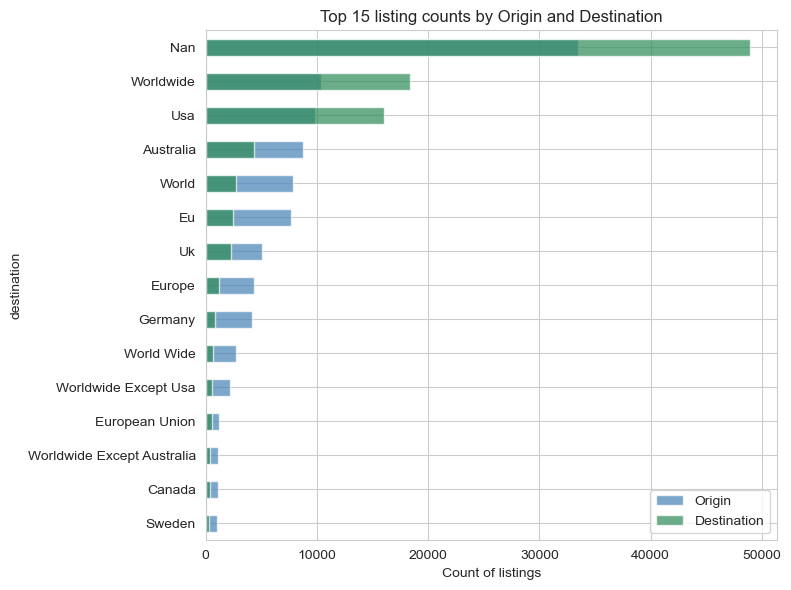


 Top 5 Origins
           count
origin          
Usa        33476
Uk         10337
Nan         9815
Australia   8746
Germany     7830

 Top 5 Destinations
             count
destination       
Nan          48893
Worldwide    18419
Usa          16052
Australia     4323
World         2728


In [9]:
# Look into origin and destination of the products:

# Origin
origin_counts = df.groupby('origin').size().sort_values(ascending=False).head(15)


# Product destination
destination_counts = df.groupby('destination').size().sort_values(ascending=False).head(15)

# Combine the two plots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot origin counts
origin_counts.plot(kind='barh', color='steelblue', alpha=0.7, ax=ax, label='Origin')

# Plot destination counts
destination_counts.plot(kind='barh', color='seagreen', alpha=0.7, ax=ax, label='Destination')

# Customize the plot
ax.invert_yaxis()
ax.set_xlabel('Count of listings')
ax.set_title('Top 15 listing counts by Origin and Destination')
ax.legend()

plt.tight_layout()
plt.show()

# Print the table
print("\n Top 5 Origins")
print(origin_counts.head(5).to_frame(name='count'))

print("\n Top 5 Destinations")
print(destination_counts.head(5).to_frame(name='count'))


### Plot analysis:
Based on our plot and table we looked at, it's clear that most product listings on the Agora marketplace came from the USA, followed by the UK, Australia, and Germany. This probably reflects that many vendors were operating from these countries. On the destination side, a lot of the data is missing—which isn’t too surprising given that this is a dark web dataset. Still, from what we could see, many items were shipped worldwide, or specifically to the USA and Australia, showing that the USA was a major player both in selling and buying.

The large number of missing destination values (shown as "NaN") could mean that some vendors chose not to share where they ship, skipped the detail altogether, or possibly even lied about it. This is something important to consider because it could affect how well our model performs, especially since we plan to use destination and origin as features in our predictions. Overall, these trends show just how widespread and international this dark web marketplace really was.


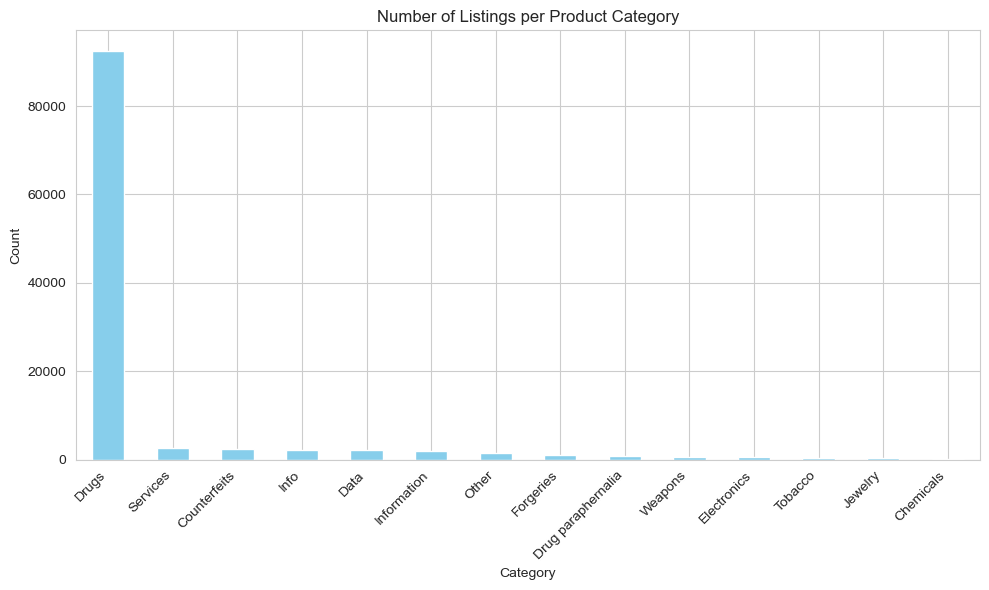

In [10]:
category_counts = df["cat1"].value_counts()
plt.figure(figsize=(10, 6))
category_counts.plot(kind="bar", color="skyblue")
plt.title("Number of Listings per Product Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From our plot above we see the different category listing and the counts of each of them. It's clear that the vast majority of listings fall under the "Drugs" category, with all other categories having significantly fewer entries. This heavy imbalance can lead to our models being biased toward predicting "Drugs" for most listings, just because it’s the most common class. To addres this issue, we will experiment with and without balancing our dataset during training so that each category is equally represented. This will help our  model learn meaningful patterns across all categories, not just the dominant one, and should improve fairness and overall performance.

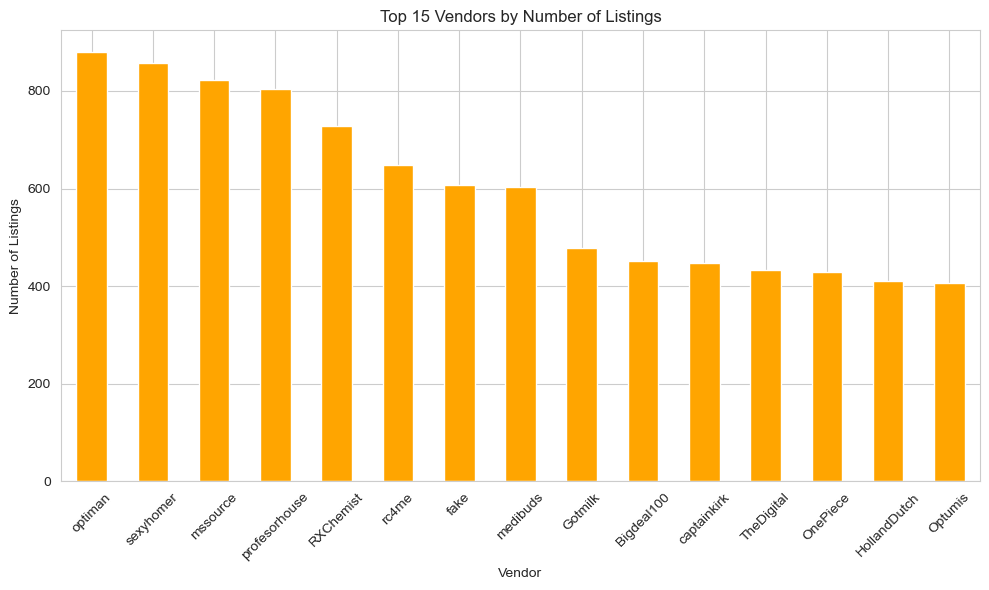

In [11]:
top_vendors = df["vendor"].value_counts().head(15)

plt.figure(figsize=(10, 6))
top_vendors.plot(kind="bar", color="orange")
plt.title("Top 15 Vendors by Number of Listings")
plt.xlabel("Vendor")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
top_vendors = [
    "optiman", "sexyhomer", "mesource", "professorhouse", "RXChemist",
    "rc4me", "fake", "medibuds", "Gotmilk", "Bigdeal100",
    "captainkirk", "TheDigital", "OnePiece", "HollandDutch", "Optumis"
]

df_top_vendors = df[df['vendor'].isin(top_vendors)]

vendor_category_table = df_top_vendors.groupby(['vendor', 'cat1']).size().unstack(fill_value=0)
display(vendor_category_table)


cat1,Chemicals,Counterfeits,Data,Drug paraphernalia,Drugs,Electronics,Forgeries,Info,Information,Jewelry,Other,Services,Tobacco,Weapons
vendor,,,,,,,,,,,,,,
Bigdeal100,0,169,0,0,0,15,2,0,0,261,4,0,0,0
Gotmilk,0,0,0,0,478,0,0,0,0,0,0,1,0,0
HollandDutch,0,0,0,0,410,0,0,0,0,0,1,0,0,0
OnePiece,0,0,1,0,1,0,93,332,0,0,0,3,0,0
Optumis,1,1,36,0,17,4,16,305,0,0,25,2,0,0
RXChemist,0,1,0,0,724,0,0,0,0,0,2,1,0,0
TheDigital,0,1,118,0,4,18,1,27,0,0,99,165,0,0
captainkirk,0,0,101,0,0,0,0,137,140,0,69,0,0,0
fake,0,26,20,1,7,14,11,53,443,4,2,22,0,5


Our graph and table above views the top vendors and the kind of products these vendors are selling. To  understand what products are being sold by the most active vendors, we looked at the top 15 vendors based on the number of listings. From the bar graph, we can see that vendors like optiman, sexyhomer, and mesource had the most listings on the Agora marketplace. To dig deeper, we created a table that shows what types of products each of these top vendors were selling.

From the table, it’s clear that many of these vendors focused mostly on Drugs, with vendors like RXChemist, rc4me, and medibuds having hundreds of drug-related listings. Something to note was that vendors also specialized in different categories( meaning they sold many kind of products and not just one.). For example, sexyhomer had a large number of Counterfeit listings, and TheDigital sold a variety of Services and Forgeries. Vendors like fake sold different things like Drug paraphernalia, Info, and even some Weapons.

This breakdown shows that even though drug listings dominate the marketplace overall, different vendors had different specialties. Understanding this helps give us a clearer picture of how diverse the illegal marketplace was and might even help explain some of the patterns our model picks up when learning from this data. And given that some vendors mostly specialize in certain products, this might be a good feature that we might use for our classification of Produc/service category.

## Building our Machine Learning Models:

After finishing our data preprocessing, we moved on to building and testing different machine learning models. Our goal was to predict the product category based on features like price, origin, destination, and vendor information.

We started by experimenting with standard models like Logistic Regression and Random Forest, using Scikit-learn. First, we did a basic train-test split to get a feel for how the models performed. Then, to improve our results, we worked on cleaning the data and balancing the classes, since some categories (like “Drugs”) were heavily overrepresented compared to others.

To further explore model performance, we also built our own custom multiclass logistic regression model using PyTorch. This allowed us to better understand the learning process, see the training loss evolve, and to also learn to implement a model from scratch.

By comparing these different approaches, we were able to evaluate how different methods like balancing data or customizing the model affected overall performance.

### Preparing our data for modeling

Before training our model, we made sure to do the following steps to trian our model.

* Selected features and target: We chose “score,” “deals,” “log_usd,” “origin,” and “destination” as the features (inputs), and “cat1” (the broad product category) as the target we want to predict.

* Handled missing values: Some listings were missing origin or destination data, so we filled those missing values with the word “Unknown” to avoid errors during training.

* Filtered the data: We removed the rows where the category (target) was missing to make sure we only trained on valid entries.

* Then we finally split the data: We divided our data into a training set and a testing set using an 80/20 split.

* Created a preprocessing pipeline: For numerical features, we filled missing values with the median and then scaled them (so they all have the same scale)And for categorical features, we filled missing values with “Unknown” and then applied one-hot encoding to turn them into binary columns (which makes them usable by our models).

This whole setup was to make sure that our data was clean, standardized, and ready to be used by our machine learning models to learn.



In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Target variable and features
target = "cat1"
features = ["score", "deals", "log_usd", "origin", "destination"] 

df_model = df.copy()  # Good practice :))

# Filling missing values
df_model[["origin", "destination"]] = df_model[["origin", "destination"]].fillna("Unknown")

# Keep rows where target is defined
df_model = df_model[df_model[target].notna()]

print(f"Final usable rows: {len(df_model):,}")

# Splits data matrix and vector
X = df_model[features]
y = df_model[target]

# Splitting further into training and testing sets (80-20 rule)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=451, stratify=y
)

# Numeric and categorical groups
num_cols = ["score", "deals", "log_usd"]
cat_cols = ["origin", "destination"]

# Preprocessed pipeline to help us later:
# ColumnTransformer allows us to apply different pre-processing steps to different columns.
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
# Using the same technique from class where we get a mean of 0 and std. dev. of 1 and binary columns.

prep = ColumnTransformer([
    ("num", Pipeline([  # Standardized
        # SimpleImputer replaces missing values using a descriptive statistic of our choosing along each column.
        # Doc: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
        ("imp", SimpleImputer(strategy="median")),  # Fill numeric gaps
        ("sc", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([  # Binarized
        ("imp", SimpleImputer(strategy="constant", fill_value="Unknown")),  # Fill NaNs
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])


Final usable rows: 109,096


### Logistic Regression Model with Class Balancing
To train our logistic regression model, we used a pipeline that combined our preprocessing steps (like scaling and encoding) with the classifier itself. We used the OneVsRest strategy, which creates a separate binary classifier for each class. This worked well for our multi-class calssification, because we have many categories like "Drugs", "Services", "Counterfeits", etc. Since our dataset was really imbalanced with some categories having way more listings than others we used class_weight="balanced" in our model. This was to help give more importance to our smaller classes too, so they wouldn’t be ignored by the model.

We trained the model and evaluated it using accuracy and F1 scores. The overall accuracy was 66.3%, which means the model got about two-thirds of predictions right. But in order to fully understand our errors we had to look at our F1 scores since we were working with multiple classes for our classification.  Our macro F1 score was 23.7%, which is quite low . This score treats each class equally, so it helps us see how well the model performs across all categories  even the ones that didnt have that many class samples. This means that even if our model performs well on the larger classes (like "Drugs"), it's doing a bad job predicting on the smaller ones (like "Chemicals", "Weapons", etc.). So this showed us that our  model is not balanced and it favored the majority class and cant correctly predict the minority ones as accurately. This shows us that we need to improve how the model handles underrepresented categories. Which we plan to do later on by by balancing the training data more or using different modeling techniques. 

Our confusion matrix shows where the model performed well and where it struggled. The model was very good at identifying "Drugs" (which had a lot of data), but less accurate for smaller categories like "Chemicals" or "Weapons". This shows why class balancing is important for making fairer models in the future.

Log. Reg. accuracy: 66.3 %
Log. Reg. F1 macro: 23.7 %
Log. Reg. F1 Micro: 66.3 %
                    precision    recall  f1-score   support

         Chemicals       0.01      0.39      0.02        18
      Counterfeits       0.32      0.63      0.43       473
              Data       0.28      0.26      0.27       423
Drug paraphernalia       0.06      0.74      0.12       168
             Drugs       0.98      0.72      0.83     18497
       Electronics       0.02      0.15      0.03       119
         Forgeries       0.10      0.23      0.14       210
              Info       0.43      0.42      0.43       433
       Information       0.31      0.54      0.39       369
           Jewelry       0.06      0.67      0.12        84
             Other       0.04      0.01      0.02       284
          Services       0.16      0.11      0.13       527
           Tobacco       0.19      0.49      0.27        84
           Weapons       0.09      0.23      0.13       131

          accurac

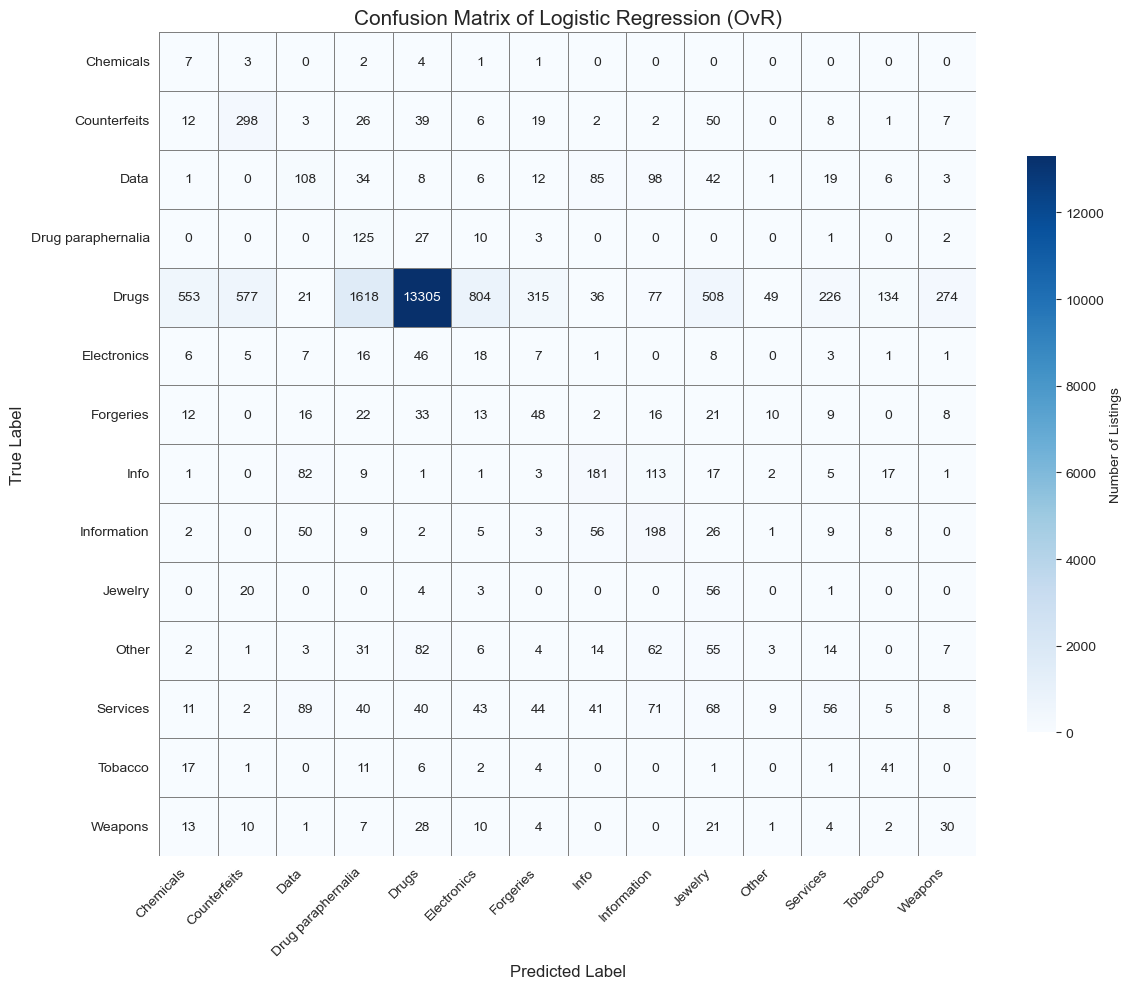

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix)

# Been reading through the documentation and realized using pipeline would make our life so much easier
# I might be using wrong parameters, so pls do let me know if there's a better one more fitted for our model. https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

log_pipe = Pipeline([("prep", prep),        # Prep refers to the ColnTransformer from our prev. code.
    ("clf",  LogisticRegression(
                max_iter=10000,             # 10k iterations
                # can use "multinomial" and compare
                multi_class="ovr",          # One binary classifier for each class, we used the one vs. rest strategy here.
                solver="lbfgs",             # lbfgs is best for small to medium dataset, which fits our dataset criteria.
                class_weight="balanced",    # Since our dataset is imbalanced based on subclass and class, it adjusts the weights of classes inversely proportional to their frequencies in the data
                C = 0.5))                   # slightly more regularization than default, often improves precision
])

# Fit & evaluate
log_pipe.fit(X_train, y_train)
y_pred_log = log_pipe.predict(X_test)

print("Log. Reg. accuracy:", round(accuracy_score(y_test, y_pred_log), 3)*100, "%")              # Simply, how often our model makes correct predictions. Accuracy fails to take minority class into acc for model eval tho.
print("Log. Reg. F1 macro:", round(f1_score(y_test, y_pred_log, average="macro"), 3)*100, "%")   # with "macro",  F1 score is calculated for each class independently, and their avg is taken, treating all classes equally unlike accuracy.
print("Log. Reg. F1 Micro:", round(f1_score(y_test, y_pred_log, average="micro"), 3)*100, "%")   # with "micro", we aggregates contributions of all class to give a good comparison metric.

# Precision is the proportion of T.P pred out of all pos. pred.
# Recall is T.P pred out of all Pos. instances.
# F1 score formula is: 2 * proportion_of_positive_class / ( 1 + proportion_of_positive_class )
print(classification_report(y_test, y_pred_log))

# Confusion Matrix Plot
labels = sorted(y_test.unique())  # ensures consistent order
cm = confusion_matrix(y_test, y_pred_log, labels=labels)

# Color intensity reflects that number, so darker blue = higher count
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt="d",
    cmap="Blues", xticklabels=labels, yticklabels=labels,
    linewidths=0.4, linecolor='gray', cbar_kws={'shrink': 0.7, 'label': 'Number of Listings'})
plt.title("Confusion Matrix of Logistic Regression (OvR)", fontsize=15)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



### Experimenting with Vendor Feature to increase accuracy
Some thing we wanted to experiment with was to add the vendor feature and see if made and changes in accuracy. So in our code below we added new features vendor and vendor activity to see if it was a good predicting feature for classification of the different products or services. 
So in our cleaned dataset df, we created a new numeric feature vendor_activity, which represents the total number of listings posted by each vendor. So now we will update our fetaure list and train our model again and see if that makes any difference in our models performance. Now that we have split our training and test data we will update our preprocessing and create our pipeline based of our numeric columns and categorical collumns. We will then train and evaluate our model again.

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Looking at count of vendors
vendor_counts = df["vendor"].value_counts()
#create a new column in the dataframe with the vendor activity
df["vendor_activity"] = df["vendor"].map(vendor_counts)

df[["vendor", "vendor_activity"]].head()


# Updated features
features = ["deals", "log_usd", "origin", "destination", "vendor_activity", "vendor"]
target = "cat1"

# Define X and y
X = df[features]
y = df[target]

# Fill missing values if needed
X["origin"] = X["origin"].fillna("Unknown")
X["destination"] = X["destination"].fillna("Unknown")
X["vendor"] = X["vendor"].fillna("Unknown")

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=451, stratify=y)

# List of numeric and categorical columns
num_cols = ["deals", "log_usd", "vendor_activity"]
cat_cols = ["origin", "destination", "vendor"]

# Create a preprocessing pipeline
prep = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

# Creating pipeline
log_pipe = Pipeline([
    ("prep", prep),
    ("clf", LogisticRegression(max_iter=3000, multi_class="ovr", class_weight="balanced"))
])

#Fiting teh model
log_pipe.fit(X_train, y_train)

# Predict on the test set
y_pred = log_pipe.predict(X_test)

# printing our Accuracy and F1 score for the new fewature
print("Logistic Regression Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("Log. Reg. F1 macro:", round(f1_score(y_test, y_pred, average="macro"), 2)*100, "%") 
print("Log. Reg. F1 Micro:", round(f1_score(y_test, y_pred, average="micro"), 2)*100, "%")


Logistic Regression Accuracy: 88.61 %
Log. Reg. F1 macro: 56.99999999999999 %
Log. Reg. F1 Micro: 89.0 %


After training the model with the new features, we saw a big improvement in performance. Our accuracy went up to 88.61%, and the macro F1 score increased to 57%, which is much better than before. This tells us that adding the vendor and vendor_activity features helped the model make more balanced predictions across all categories, especially for the smaller ones. This makes sense because some vendors tend to sell specific types of products, so including vendor information gave the model more useful patterns to learn from.

## Fine tuning our model using hyper parameter tuning
After seeing better performance for our model, we wanted to fine-tune the model even more using hyperparameter tuning. We used GridSearchCV, which tries different values for a chosen parameterand finds the best one using 5-fold cross-validation. This means that it splits the training data into 5 parts and checks how well each version of the model performs using the macro F1 score, which is helpful since our classes are imbalanced. The best setup from this grid search gives us the most balanced and generalizable logistic regression model. The pipeline also includes preprocessing steps like scaling numerical features and one-hot encoding categorical ones.


In [16]:
from sklearn.model_selection import GridSearchCV
# Logistic Regression pipeline
log_pipe = Pipeline([
    ("prep", prep),
    ("clf", LogisticRegression(max_iter=1000, multi_class="ovr", class_weight="balanced"))
])

# Grid of hyperparameters to search
param_grid_log = {
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100]
}

#setting up 5-fold cross-validation
grid_log = GridSearchCV(
    log_pipe,
    param_grid_log,
    cv=5,  # 5-fold cross-validation
    scoring="f1_macro",  #macro F1 score
    n_jobs=-1  # use all cores
)

# Train grid search
grid_log.fit(X_train, y_train)

/Users/prashanthbabu/anaconda3/envs/ml-0451/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/prashanthbabu/anaconda3/envs/ml-0451/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/prashanthbabu/anaconda3/envs/ml-0451/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/prashanthbab

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['deals',
                                                                          'log_usd',
                                                                          'vendor_activity']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(fill_value='Unknown',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['origin',
                                                                          'destination',
                                                                          'vendor'])])),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='ovr'))]),
             n_jobs=-1, param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='f1_macro')

So now after fitting our fine tuned model we evaluated our accuracy on it and saw good performance. The overall accuracy reached 88.95%, and the macro F1 score—which treats all classes equally—went up to 58.12%, which again is really good compared to our earlier results.

Looking at the per-class scores, we can see that the model now does well not only on the “Drugs” category (which has the most data), but also performs better on smaller categories like “Jewelry”, “Weapons”, “Information”, and “Services”. The precision and recall values are more balanced across the board, meaning the model is making fewer mistakes when it predicts each class.

Some small categories like “Chemicals” and “Other” are still hard to predict, but overall the results show that tuning helped our model become more fair and accurate across all product types.


In [17]:
y_pred_best = grid_log.predict(X_test)

print("Logistic Regression (Tuned) Accuracy:", round(accuracy_score(y_test, y_pred_best)*100, 2), "%")
print("Log. Reg. (Tuned) F1 macro:", round(f1_score(y_test, y_pred_best, average="macro")*100, 2), "%")

# Classification report
print(classification_report(y_test, y_pred_best))

Logistic Regression (Tuned) Accuracy: 88.95 %
Log. Reg. (Tuned) F1 macro: 58.12 %
                    precision    recall  f1-score   support

         Chemicals       0.12      0.61      0.20        18
      Counterfeits       0.81      0.80      0.81       473
              Data       0.69      0.60      0.64       423
Drug paraphernalia       0.43      0.85      0.57       168
             Drugs       0.99      0.93      0.96     18497
       Electronics       0.26      0.55      0.35       119
         Forgeries       0.50      0.73      0.59       210
              Info       0.73      0.68      0.71       433
       Information       0.57      0.85      0.68       369
           Jewelry       0.56      0.81      0.66        84
             Other       0.16      0.40      0.23       284
          Services       0.50      0.52      0.51       527
           Tobacco       0.45      0.82      0.58        84
           Weapons       0.53      0.82      0.64       131

          accura

### Random Forest Classifier

After testing logistic regression, we decided to try a Random Forest classifier to see if it could improve our results. We used the same pipeline, but replaced the logistic regression model with a random forest. We set it up with 500 trees and used class balancing to help deal with the imbalance in our class as some product categories had way more listings than others.

The results were a lot better than our logistic regression model:

* Our accuracy went up to 94.8%

* Macro F1 score increased to 74.1%

This improvement was because Random Forests are better at handling complex, nonlinear patterns in data, especially when there are many features and different types of variables (like price, origin, and vendor). They are also less sensitive to imbalanced data, especially when we use the class_weight="balanced" option, which helps the model pay attention to smaller categories that would normally get ignored.

So we saw that our Random Forest model turned out to perform really good for this classification problem, giving us more accurate and fair predictions across all product categories.

In [18]:
# Just replacing the classifier in the same pipeline:
rf_pipe = Pipeline([
    ("prep", prep),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,            # setting to none to avoid overfitting
        random_state=451,
        class_weight="balanced",   # handles class imbalance
        n_jobs=-1                  # uses all CPU cores
    ))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

print("Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3)*100, "%")
print("Random Forest Macro F1:", round(f1_score(y_test, y_pred_rf, average="macro"), 3)*100, "%")
print("Random Forest Micro F1:", round(f1_score(y_test, y_pred_rf, average="micro"), 3)*100, "%")
print(classification_report(y_test, y_pred_rf))


KeyboardInterrupt: 

## We already are getting really good results compared to our base model. I'll now trying to make it such that our hyperparameters are being tuned automatically:

- Using GridSearch CV to do the exhaustive search on behalf of us. Read through the documentation to learn the implementation and parameters.
- Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score

rf_pipe = Pipeline([
    ("prep", prep),  
    ("clf", RandomForestClassifier(
        random_state=451,
        class_weight="balanced",
        n_jobs=-1 
    ))
])

#Defining our parameter grid for tuning
param_grid_rf = {
    "clf__n_estimators": [100, 300, 500],
    "clf__max_depth": [None, 10, 20, 50],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}


grid_rf = GridSearchCV(
    rf_pipe,
    param_grid=param_grid_rf,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_rf.fit(X_train, y_train)

# Predict with best model
best_rf_model = grid_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate performance
print("Random Forest (Tuned) Accuracy:", round(accuracy_score(y_test, y_pred_rf) * 100, 2), "%")
print("Random Forest (Tuned) F1 macro:", round(f1_score(y_test, y_pred_rf, average="macro") * 100, 2), "%")
print("\n", classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time= 4.6min
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time= 4.7min
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time= 4.7min
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time= 4.8min
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time= 4.9min
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=13.9min
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=14.0min
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_spli

In [19]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

# full pipeline
rf_pipe = Pipeline([
    ("prep", prep),  # existing ColumnTransformer
    ("clf", RandomForestClassifier(
        class_weight="balanced",
        random_state=451,
        n_jobs=-1
    ))
])

# Set up grid of hyperparameters to search
'''
Initial search:
param_grid = {
    "clf__n_estimators": [100, 300],       # number of trees
    "clf__max_depth": [10, 20, None],      # limit tree depth
    "clf__min_samples_split": [2, 5],      # when to split a node
    "clf__min_samples_leaf": [1, 2]        # min samples in a leaf node
}
Best Params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}

param_grid = {
    "clf__n_estimators": [300, 600, 900],            # already good at 300; try larger
    "clf__max_depth": [None, 30, 50],                # test whether some limit helps generalization
    "clf__min_samples_split": [2, 5, 10],            # stricter splits to combat overfitting
    "clf__min_samples_leaf": [1, 2, 4]               # test slightly larger leaves
}
# Best Params: {'clf__max_depth': 50, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
# Random Forest Accuracy: 91.10000000000001 %
#Random Forest Macro F1: 58.8 %
'''
param_grid = {
    "clf__n_estimators": [200, 250, 300, 350],            # already good at 300; try larger
    "clf__max_depth": [30, 50, None],                # test whether some limit helps generalization
    "clf__min_samples_split": [1, 2],            # stricter splits to combat overfitting
    "clf__min_samples_leaf": [1]               # test slightly larger leaves
}

# Run the search
grid_search = GridSearchCV(
    # F1 Macro: Treats all samples equally, regardless of class. So good for overall accuracy across the dataset.
    # F1 Micro: Each class matters equally, regardless of size. So better for imbalanced multiclass classification
    rf_pipe, param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=3         # CHange Verbose to 1 or 2 to see more details
)

grid_search.fit(X_train, y_train)

# View best parameters and evaluate on test set
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_rf = best_model.predict(X_test)

print("Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3)*100, "%")
print("Random Forest Macro F1:", round(f1_score(y_test, y_pred_rf, average="macro"), 3)*100, "%")
#print("Random Forest Micro F1:", round(f1_score(y_test, y_pred_rf, average="micro"), 3)*100, "%")
print(classification_report(y_test, y_pred_rf))


cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[["params", "mean_test_score", "std_test_score"]].head(10)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END clf__max_depth=30, clf__min_samples_leaf=1, clf__min_samples_split=1, clf__n_estimators=200;, score=nan total time=   0.2s
[CV 2/3] END clf__max_depth=30, clf__min_samples_leaf=1, clf__min_samples_split=1, clf__n_estimators=200;, score=nan total time=   0.2s
[CV 3/3] END clf__max_depth=30, clf__min_samples_leaf=1, clf__min_samples_split=1, clf__n_estimators=200;, score=nan total time=   0.2s
[CV 1/3] END clf__max_depth=30, clf__min_samples_leaf=1, clf__min_samples_split=1, clf__n_estimators=250;, score=nan total time=   0.1s
[CV 2/3] END clf__max_depth=30, clf__min_samples_leaf=1, clf__min_samples_split=1, clf__n_estimators=250;, score=nan total time=   0.1s
[CV 3/3] END clf__max_depth=30, clf__min_samples_leaf=1, clf__min_samples_split=1, clf__n_estimators=250;, score=nan total time=   0.1s
[CV 1/3] END clf__max_depth=30, clf__min_samples_leaf=1, clf__min_samples_split=1, clf__n_estimators=300;, score=nan total 

KeyboardInterrupt: 

### RFC Result Analysis:

## Feature Importance (RF only)

## Cross-Validation Snapshot

### Experimenting with Manually Balancing Our Dataset for Training and Testing on Unseen Data

In the experiment below, we wanted to test how a model trained on a balanced dataset would perform on unseen data. To do this, we first downsampled our dataset to make sure that all classes had a similar number of samples. We then trained our model on this balanced data and tested it on the remaining unused data—which served as unseen data for the model.

We can see from our graph below that drugs was the biggest category in our classes for the classification task, we noticed taht our model could randomly guess drugs and be correct most of the times. So we plan on undersampling our data to make it more balanced and usefule and train using that data.

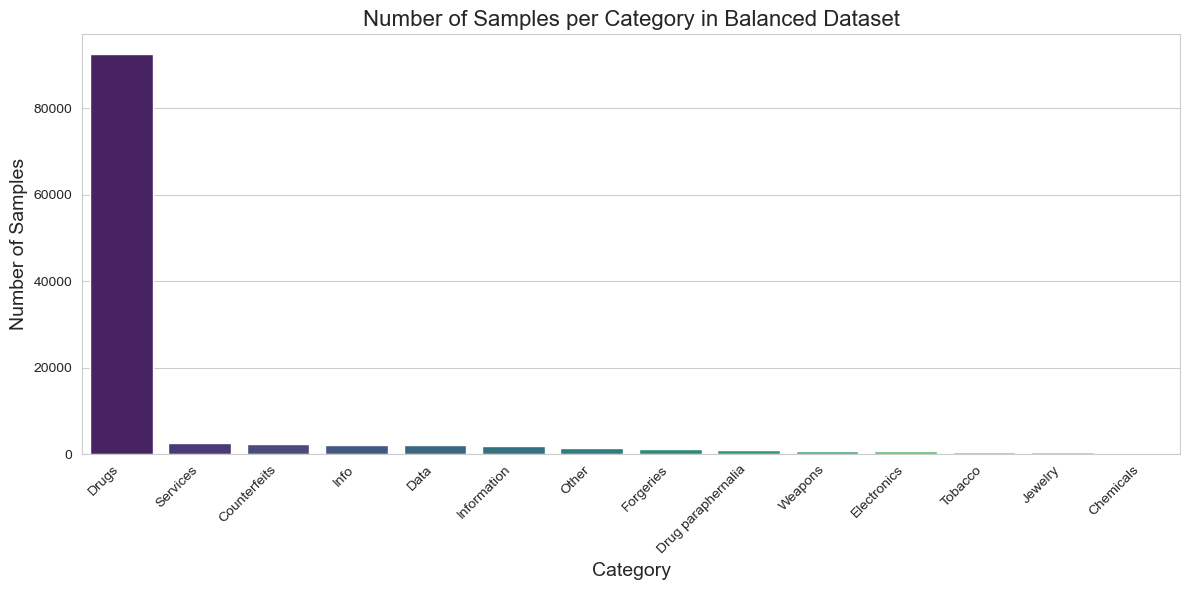

In [20]:

plt.figure(figsize=(12, 6))
sns.countplot(data=df_model, x="cat1", order=df_model["cat1"].value_counts().index, palette="viridis")

plt.title("Number of Samples per Category in Balanced Dataset", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


plt.show()

In [21]:
# check unique values in the target column
df_model["cat1"].value_counts()

cat1
Drugs                 92483
Services               2636
Counterfeits           2367
Info                   2167
Data                   2115
Information            1843
Other                  1420
Forgeries              1048
Drug paraphernalia      840
Weapons                 654
Electronics             596
Tobacco                 419
Jewelry                 418
Chemicals                90
Name: count, dtype: int64

### Deciding sampling size
We checked the number of samples in each class to see how big each class size was and to decide what value to downsample our data to. Our data was very imbalance, as we can see "Drugs" category had over 92,000 listings, some others like "Chemicals" and "Jewelry" had fewer than 500. To make our classification more fair and to avoid misleading accuracy results, we planned to downsample the larger classes (especially "Drugs") so that all classes are more balanced. 

Since some classes had extremely small counts (like 90 for "Chemicals"), we decided not to include those because balancing everything to just 90 samples would mean throwing away too much data. Instead, we dropped any category with fewer than 500 listings. For the remaining categories, we chose to sample 600 listings per class because most of them had at least that 600.


Since some of these samples in our dataset have only 90 samples etc.. we will get rid of them as if we balance all  our data to 90 samples, we will lose too much data. So we are going to Drop categories with < 500 samples because they're too small to be reliable( Tobacco, Jewelry, Chemicals). For the remaining categories, we will pick 600 samples per class because most have ≥ 600.

In [22]:
#keeping the catgeoris that have (>= 500 samples)
categories_to_keep = df_model["cat1"].value_counts()[df_model["cat1"].value_counts() >= 500].index.tolist()

#Filtering our data
df_balanced = df_model[df_model["cat1"].isin(categories_to_keep)].copy()

#creating sample 600 for each category
balanced_samples = []

for category in categories_to_keep:
    df_category = df_balanced[df_balanced["cat1"] == category]
    if len(df_category) >= 600:
        sampled = df_category.sample(600, random_state=42)
    else:
        sampled = df_category  #if category has less than 600, keep all
    balanced_samples.append(sampled)

#Combine them
df_balanced = pd.concat(balanced_samples, ignore_index=True)

# Check the new counts of our evenly sampled data
print(df_balanced["cat1"].value_counts())

cat1
Drugs                 600
Services              600
Counterfeits          600
Info                  600
Data                  600
Information           600
Other                 600
Forgeries             600
Drug paraphernalia    600
Weapons               600
Electronics           596
Name: count, dtype: int64


We can now see in our graph that we have downsampled our class size for our training data to have around 600 samples for each class.

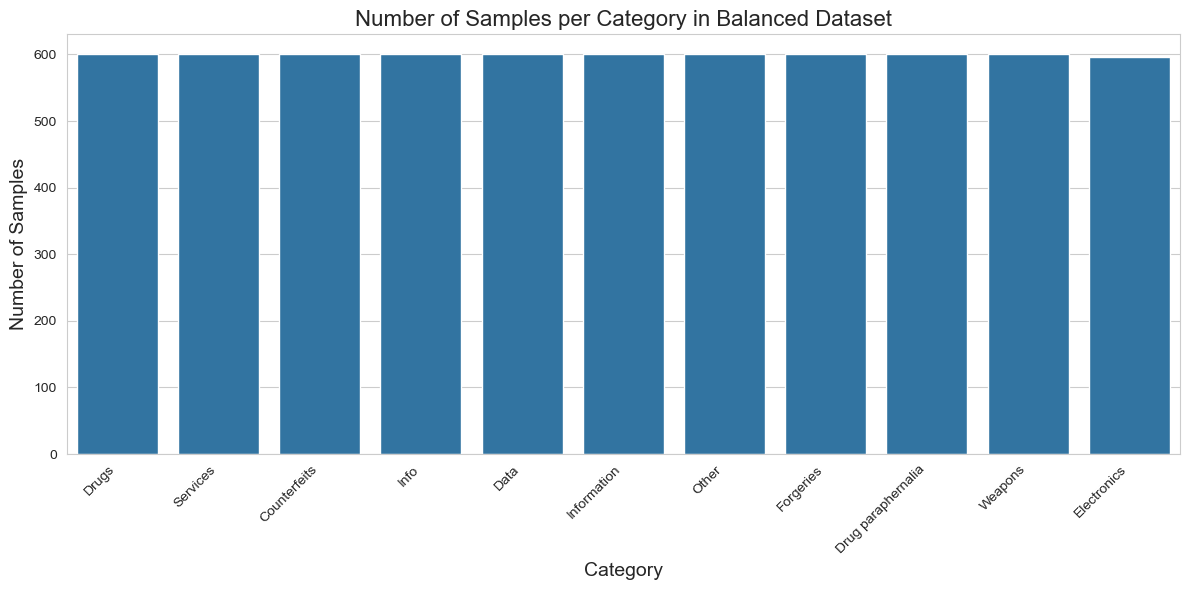

In [23]:

plt.figure(figsize=(12, 6))
sns.countplot(data=df_balanced, x="cat1", order=df_balanced["cat1"].value_counts().index)

plt.title("Number of Samples per Category in Balanced Dataset", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


plt.show()

### Preprocessing for Balanced Training and Testing Data

After balancing our data by selecting an equal number of samples from each category, we prepared the features again for model training and testing. First, we dropped any rows from our balanced dataset that had missing values in important columns like price, origin, or vendor. Then, we selected the key features we wanted to use i.e. log_usd, deals, origin, destination, and vendor.

Since some of these features are categorical, we applied one-hot encoding to them so that the model could work with them numerically. For the numerical columns (log_usd and deals), we used standard scaling so that all values are on a similar scale.

Once we had the cleaned and encoded training data, we also created a test set using the unused data (the rows that were not part of our balanced training set). We applied the same encoder and scaler to the test data to make sure it’s formatted the same way as the training data. This let us to evaluate how well our model performs on data it hasn’t seen during training.

In [24]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split


df_balanced = df_balanced.dropna(subset=["log_usd", "deals", "origin", "destination", "vendor", "cat1"])
X = df_balanced[["log_usd", "deals", "origin", "destination", "vendor",]]
y = df_balanced["cat1"]


# One-hot encoding our categorical features
categorical_cols = ["origin", "destination", "vendor"]
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = ohe.fit_transform(X[categorical_cols])

# Scaling the numerical features
numerical_cols = ["log_usd", "deals"]
scaler = StandardScaler()
X_num = scaler.fit_transform(X[numerical_cols])

#finally combining them and keep it for using to train our model
import numpy as np
X_processed = np.hstack([X_num, X_cat])

# since we only samples ome data and there is a bunch of data we didnt use, we plan to use it for testing
# So we need to create a new dataframe for the unused data
# Create a new dataframe for unused data by comparing the rows in df and df_balanced
df_unused = df_model.merge(df_balanced, how='outer', indicator=True)
df_unused = df_unused[df_unused['_merge'] == 'left_only'].drop(columns=['_merge'])
df_unused = df_unused.dropna(subset=["log_usd", "deals", "origin", "destination", "vendor", "cat1"])


# Prepare X_test and y_test
X_test = df_unused[["log_usd", "deals", "origin", "destination", "vendor",]]
y_test = df_unused["cat1"]



# Encode test categorical features using SAME encoder & scaler
X_test_cat = ohe.transform(X_test[categorical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])
X_test_processed = np.hstack([X_test_num, X_test_cat])



Since we trained our model using only a selected set of categories, we first filtered the test data to include only those same categories. Then, we took a small sample of up to 100 listings per category from the unused data to create a balanced and fair test set. After that, we did the same preprocessing steps to prepare our features. This is so that we can test how well our model generalizes to new data while keeping class sizes consistent.

In [25]:
# Keep only our categories we used in training
categories_used = df_balanced["cat1"].unique()
df_unused_filtered = df_unused[df_unused["cat1"].isin(categories_used)].copy()

#creating a sample of 100 per category
test_samples = []

for category in categories_used:
    df_cat = df_unused_filtered[df_unused_filtered["cat1"] == category]
    sample_n = min(100, len(df_cat))  # edge case if there aren't 100 
    test_samples.append(df_cat.sample(sample_n, random_state=42))

# Combine all samples into test set
df_test_small = pd.concat(test_samples, ignore_index=True)

# Prepare X_test and y_test
X_test = df_test_small[["log_usd", "deals", "origin", "destination", "vendor"]]
y_test = df_test_small["cat1"]

# Encode with existing encoder/scaler
X_test_cat = ohe.transform(X_test[categorical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])
X_test_processed = np.hstack([X_test_num, X_test_cat])


Now we will train our model on our balanced and sampled dat and then test it on our dataset. we are using a multi class calssifation model because we have many dif categroies to predict from.

In [26]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs", random_state=42)
clf.fit(X_processed, y)


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

### Testing our Model on unseen data

After training our logistic regression model on our new balanced dataset, we wanted to see how well it performs on completely unseen data. To do this, we made sure our test data only included the same categories we trained on. We then cleaned the test set and made predictions using our trained model.

The test accuracy we got was around 64.5%, which shows that while the model learned something, it still finds it hard generalizing to unseen data. This is proabably because our real world data is really messy abnd aslo teh fact that our class sample size for training was really small where as the testing size is very diferent and a lot more random. For instance there might be vendors that our model hasnt even seen in the training data, that causes it to guess the wrong categroy. This shows how important it is to balance our training data but also make sure your model can generalize well beyond the training set.

In [27]:
# Making prediction on our test set now based of the classes we trained on
test_mask = y_test.isin(clf.classes_)
X_test_clean = X_test_processed[test_mask]
y_test_clean = y_test[test_mask]


y_pred = clf.predict(X_test_clean)

accuracy = accuracy_score(y_test_clean, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.6452830188679245


### Auditing our results and errors

In our confusion matrix below we can see how our model performed on data it had never seen before. Most of the correct predictions are along the diagonal, and according to our accuracy it got is right 64 percent of the time.

Some categories like Counterfeits and Information were predicted really well. Others, like Services, Drugs, and Forgeries, were also predicted decently but had some confusion with similar categories.

We also noticed that Electronics has all zeros. This isn’t because the model couldn’t predict Electronics, but because our test sample didn’t have any Electronics listings. So, the model didn’t get a chance to make any predictions for that class.

Overall, this shows our model works pretty well but it finds it hard to predict certain categories. This also shows that the test data should have samples from each class to get a full picture of model performance.

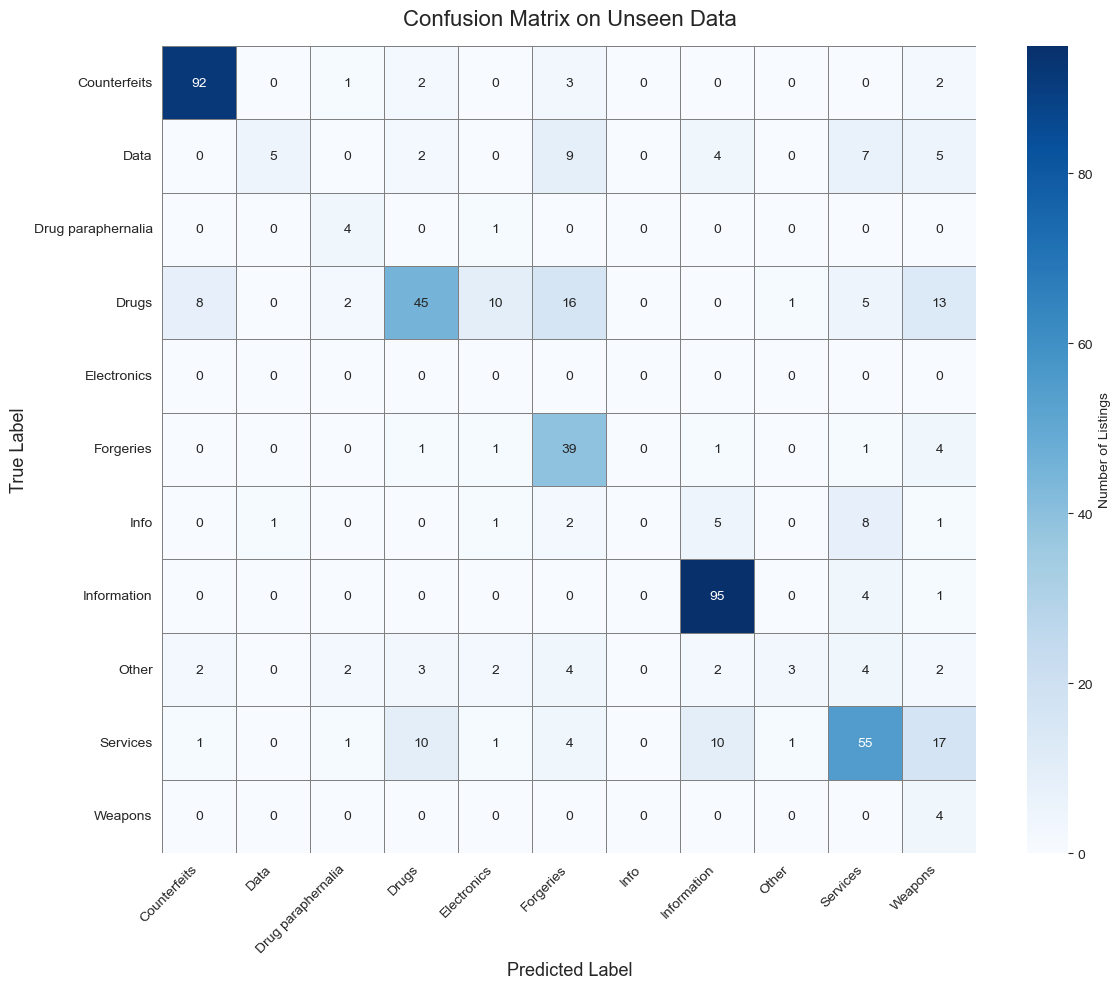

In [28]:
labels = clf.classes_

cm = confusion_matrix(y_test_clean, y_pred, labels=labels)

# Plot the confusion matrix 
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels,
            linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Number of Listings'})

plt.title("Confusion Matrix on Unseen Data", fontsize=16, pad=15)
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_test_clean, y_pred))

                    precision    recall  f1-score   support

      Counterfeits       0.89      0.92      0.91       100
              Data       0.83      0.16      0.26        32
Drug paraphernalia       0.40      0.80      0.53         5
             Drugs       0.71      0.45      0.55       100
       Electronics       0.00      0.00      0.00         0
         Forgeries       0.51      0.83      0.63        47
              Info       0.00      0.00      0.00        18
       Information       0.81      0.95      0.88       100
             Other       0.60      0.12      0.21        24
          Services       0.65      0.55      0.60       100
           Weapons       0.08      1.00      0.15         4

          accuracy                           0.65       530
         macro avg       0.50      0.53      0.43       530
      weighted avg       0.71      0.65      0.64       530



From our classification report we saw thatour logistic regression model achieved around 65% accuracy on the unseen test set, but the performance varied a lot between categories. Some classes like Counterfeits, Information, and Services had relatively strong F1 scores (above 0.60), showing that the model was able to detect clear patterns for those labels. But other classes like Electronics, Info, and Weapons had very low or even zero F1 scores, showing the model struggled when the test set had very few or no examples for those categories. For example, Electronics had no examples at all in the test data (support = 0), so the model didn’t get a chance to predict it.

This shows a common challenge in multi-class classification: even after balancing the training data, real-world test data can still be unbalanced  in certain classes. This makes it hard for our logistic regression to generalize well to all categories, especially rare ones.

Because of this, we decided to try Random Forest, which is a more powerful model that can learn nonlinear relationships, handle imbalanced data better, and is often more accurate at identifying less frequent classes.


In [30]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_processed, y)

# Predict only on test samples with valid labels
test_mask_rf = y_test.isin(rf.classes_)
X_test_clean_rf = X_test_processed[test_mask_rf]
y_test_clean_rf = y_test[test_mask_rf]

# Predict
y_pred_rf = rf.predict(X_test_clean_rf)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test_clean_rf, y_pred_rf))
print(classification_report(y_test_clean_rf, y_pred_rf, target_names=rf.classes_))

Random Forest Accuracy: 0.6735849056603773
                    precision    recall  f1-score   support

      Counterfeits       0.85      0.93      0.89       100
              Data       0.79      0.34      0.48        32
Drug paraphernalia       0.28      1.00      0.43         5
             Drugs       0.71      0.51      0.59       100
       Electronics       0.00      0.00      0.00         0
         Forgeries       0.65      0.74      0.69        47
              Info       0.67      0.22      0.33        18
       Information       0.82      0.93      0.87       100
             Other       0.60      0.12      0.21        24
          Services       0.64      0.58      0.61       100
           Weapons       0.14      1.00      0.24         4

          accuracy                           0.67       530
         macro avg       0.56      0.58      0.49       530
      weighted avg       0.73      0.67      0.68       530



Our random forest classifier trained on our balanced data got an overall accuracy of about 67%. While this is slightly better than our logistic regression model, the most important improvement was in the F1 scores for many of the smaller or mid sized classes. For example, categories like Forgeries, Information, and Services we see F1 scores above 0.60.

Some rare classes like Weapons and Drug paraphernalia had high recall (meaning the model caught most of them), but their precision was low, which means that there were a lot of false positives. On the other hand, Electronics had 0 precision and recall, because there were no examples of it in the test set, so we couldn't test its performance on it properly.

This shows that Random Forest handled imbalanced data and complex patterns better than logistic regression. It gave us stronger and more balanced performance. However, it still struggled with extremely rare classes but did better.

Text(122.72222222222221, 0.5, 'True Label')

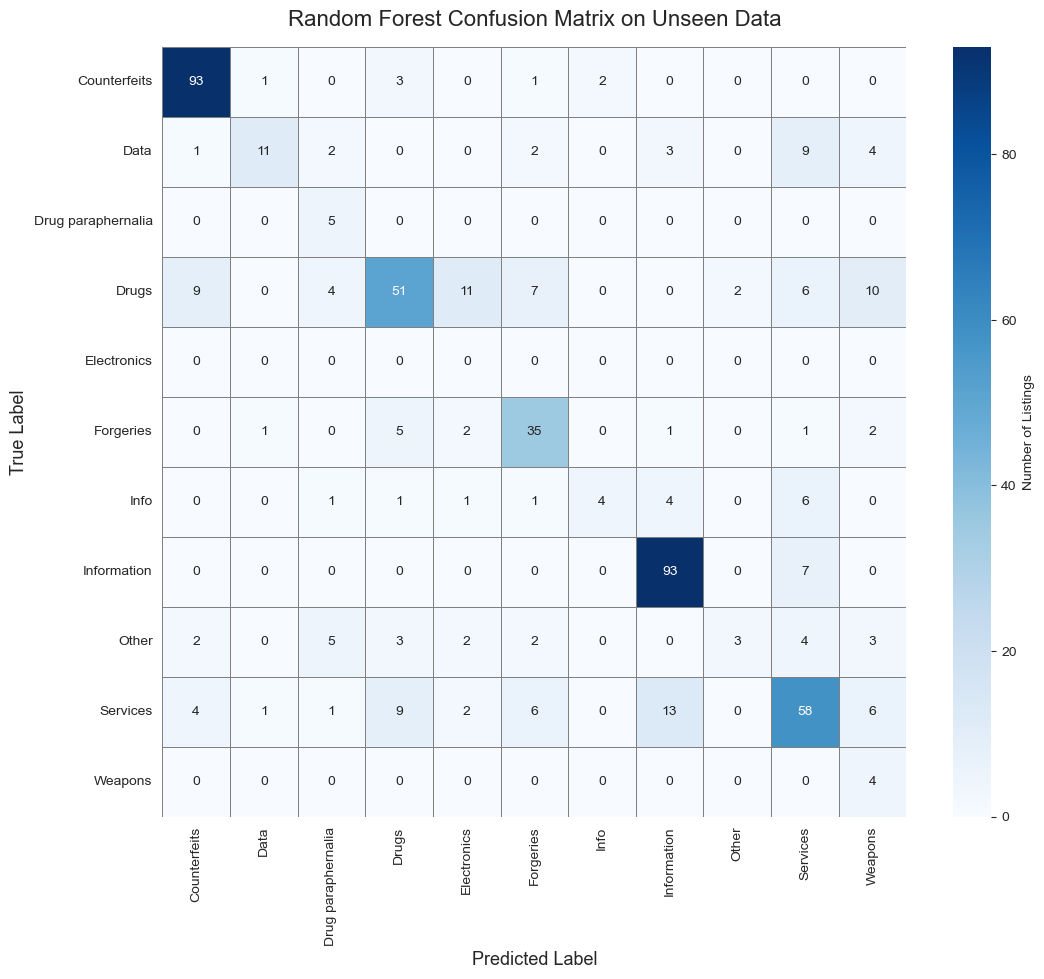

In [31]:
confusion_matrix_rf = confusion_matrix(y_test_clean_rf, y_pred_rf, labels=rf.classes_)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf.classes_, yticklabels=rf.classes_,
            linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Number of Listings'})
plt.title("Random Forest Confusion Matrix on Unseen Data", fontsize=16, pad=15)
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)




Looking at our confusion matriz shows strong diagonal lines for "Information" and "Counterfeits"; This means there were many correct predictions for those, while scattered off-diagonal values for "Drugs", "Services", and "Other" show overlap and confusion between these similar categories.

This experiment shows that even though we balanced the training data, the imbalance in the test set still affects how well the model can generalize—especially for the smaller or more ambiguous classes. Still, Random Forest did a better job than logistic regression in handling these edge cases and is more robust for this kind of real-world, imbalanced, multi-class dataset.

## Building our own logistic regression model and evaluating that model
We now plan to train using our own logistic regression model that we will be building from scratch. In order to that, we will need to first convert the data to pytroch tensors. 
In class we created a binary logistic regression model that learned a single weight vector $\mathbf{w}$ to predict if a sample belonged to one of two classes. The model we created worked by calculating scores as $\mathbf{s} = \mathbf{X} \mathbf{w}$, to which we applied a sigmoid function to get the probabilities. We then used an average logistic loss for training. Our gradients were calulated based off the difference between predicted probabilities and true labels, and we updated our weights using gradient descent with momentum.

However, our project we are working on now has multiple categories that it needs to classify from. So to do this, we need to make our model a multiclass logistic regression (which is also called softmax regression). We did this by first:

*  Instead of a weight vector $\mathbf{w}$, we use a weight matrix $\mathbf{W}$ with shape $(p, K)$, where p is the number of features and K is the number of classes. Each column would correspond to one class.

* We then calculated our scores as $\mathbf{S} = \mathbf{X} \mathbf{W}$, making a vector of scores for each class for each sample.

* We then had to change the sigmoid function to the softmax function, which converts scores into probabilities across all classes.

* For the loss function we had to change it to a cross-entropy loss, and compare predicted probabilities with the true class labels.

* Lastly, our gradients are now matrices that store the difference between predicted probabilities and the actual labels for each class. These gradients are used to update the weight matrix using gradient descent with momentum, allowing the model to learn to distinguish among multiple classes.

These changes help our model to classify inputs into multiple classes like Drugs, Services, Weapons, and others.

We learnt these concepts by reading this article [Multiclass logistic regression from scratch](https://medium.com/data-science/multiclass-logistic-regression-from-scratch-9cc0007da372)

So basically to imnplement this model from binary to multiclass logistic regression we had to move from a single weight vector and sigmoid to a weight matrix and softmax, adn update both our forward and backward passes. 

In [33]:
import torch
import torch.nn.functional as F # for activation functions

# Encode class labels
class_names = np.unique(df_balanced["cat1"])
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

# Prepare y
y_train = df_balanced["cat1"].map(class_to_idx)

# Convert to tensors (no `.values` needed for numpy arrays)
X_train_tensor = torch.tensor(X_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_clean, dtype=torch.float32)
y_test_clean_tensor = torch.tensor(y_test_clean.map(class_to_idx).values, dtype=torch.long)

# Add bias column (1s)
X_train_bias = torch.cat([X_train_tensor, torch.ones(X_train_tensor.shape[0], 1)], dim=1)
X_test_bias = torch.cat([X_test_tensor, torch.ones(X_test_tensor.shape[0], 1)], dim=1)


In our code belwo we will train our custom model.

In [34]:
#adding our bias term (column of 1s) to training and test tensors
X_train_bias = torch.cat([X_train_tensor, torch.ones(X_train_tensor.size(0), 1)], dim=1)
X_test_bias = torch.cat([X_test_tensor, torch.ones(X_test_tensor.size(0), 1)], dim=1)

num_features = X_train_bias.shape[1]
num_classes = len(class_names)


Here we will import our Logistic regression model and initializing model and optimizer

In [35]:
%load_ext autoreload
%autoreload 2
from multi_class_logistic import LogisticRegressionMultiClass, GradientDescentOptimizerMultiClass

model = LogisticRegressionMultiClass(num_features, num_classes)
optimizer = GradientDescentOptimizerMultiClass(model)


### Training our model

Our code below trains our custom multiclass logistic regression model over 1000 epochs using gradient descent with momentum. We use a learning rate (alpha) of 0.01 and a momentum value (beta) of 0.98 to help the model converge faster and avoid getting stuck. Every 10 epochs, we printed the current loss to track how the model is improving during training.

In [36]:
num_epochs = 1000
alpha = 0.01  # our learning rate
beta = 0.98   #momentum

for epoch in range(num_epochs):
    loss = model.loss(X_train_bias, y_train_tensor)
    optimizer.step(X_train_bias, y_train_tensor, alpha=alpha, beta=beta)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 10/1000, Loss: 2.5359
Epoch 20/1000, Loss: 2.3533
Epoch 30/1000, Loss: 2.1338
Epoch 40/1000, Loss: 1.9505
Epoch 50/1000, Loss: 1.8340
Epoch 60/1000, Loss: 1.7577
Epoch 70/1000, Loss: 1.6851
Epoch 80/1000, Loss: 1.6086
Epoch 90/1000, Loss: 1.5394
Epoch 100/1000, Loss: 1.4852
Epoch 110/1000, Loss: 1.4431
Epoch 120/1000, Loss: 1.4051
Epoch 130/1000, Loss: 1.3657
Epoch 140/1000, Loss: 1.3246
Epoch 150/1000, Loss: 1.2849
Epoch 160/1000, Loss: 1.2497
Epoch 170/1000, Loss: 1.2197
Epoch 180/1000, Loss: 1.1932
Epoch 190/1000, Loss: 1.1684
Epoch 200/1000, Loss: 1.1444
Epoch 210/1000, Loss: 1.1215
Epoch 220/1000, Loss: 1.1003
Epoch 230/1000, Loss: 1.0807
Epoch 240/1000, Loss: 1.0626
Epoch 250/1000, Loss: 1.0454
Epoch 260/1000, Loss: 1.0288
Epoch 270/1000, Loss: 1.0130
Epoch 280/1000, Loss: 0.9979
Epoch 290/1000, Loss: 0.9838
Epoch 300/1000, Loss: 0.9705
Epoch 310/1000, Loss: 0.9578
Epoch 320/1000, Loss: 0.9456
Epoch 330/1000, Loss: 0.9339
Epoch 340/1000, Loss: 0.9225
Epoch 350/1000, Loss: 0

### testing and evaluating results

After training our custom multiclass logistic regression model, we used it to make predictions on the test set. We applied the softmax function to convert our model’s output scores into class probabilities, and then selected the class with the highest probability for each sample as the predicted label. Finally, we compared these predictions to the true labels and calculated the overall test accuracy, which came out to around 63.2%. This shows that our hand-built model was able to generalize pretty well, but not as strong as models like Random Forest.

In [38]:
# making predictions
with torch.no_grad():
    test_scores = model.score(X_test_bias)
    test_probs = F.softmax(test_scores, dim=1)
    test_preds = torch.argmax(test_probs, dim=1)

# Calculating accuracy
test_accuracy = (test_preds == y_test_clean_tensor).float().mean().item()
print(f"Test Accuracy: {test_accuracy:.4f}")


# Calculating F1 macro score
test_f1_macro = f1_score(y_test_clean_tensor.cpu(), test_preds.cpu(), average='macro')
print(f"Test F1 Macro: {test_f1_macro:.4f}")

Test Accuracy: 0.6321
Test F1 Macro: 0.4207


# COnculsuon and Future work